In [1]:
import pandas as pd
from robo_trader import Trader
from robo_trader.feeds import YFinanceFeed
import json
import matplotlib.pyplot as plt

In [2]:
from robo_trader.strategy import Strategy
from robo_trader.portfolio import Portfolio
from advanced_ta import LorentzianClassification
from ta.volume import money_flow_index as MFI
import pandas as pd
import warnings
from dataclasses import dataclass

# Suppress specific warning from numpy
warnings.filterwarnings("ignore", message="All-NaN slice encountered")

@dataclass
class LorentzianSettings:
    position_size: float = 0.25
    trailing_stop: float = 0.01

class LorentzianStrategy(Strategy):
    def __init__(self, settings: LorentzianSettings):
        super().__init__()
        self.settings = settings

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        min_data_for_adx = max(20, 20) * 2
        if (True or False) and len(prices) <= min_data_for_adx:
            return

        lc = self.get_lorentzian_predictions(prices)        
        last_price_point_prediction = lc.data.iloc[-1]

        if not pd.isna(last_price_point_prediction['startLongTrade']):
            portfolio.open_long(symbol, self.settings.position_size, self.settings.trailing_stop)

    def get_lorentzian_predictions(self, prices):
        lc = LorentzianClassification(
            prices,    
            [
                LorentzianClassification.Feature("RSI", 14, 2),
                LorentzianClassification.Feature("WT", 10, 11),
                LorentzianClassification.Feature("CCI", 20, 2),
                LorentzianClassification.Feature("ADX", 20, 2),
                MFI(prices['high'], prices['low'], prices['close'], prices['volume'], 14)
            ],
            settings=LorentzianClassification.Settings(
                source='close',
                neighborsCount=8,
                maxBarsBack=2000,
                useDynamicExits=False
            ),
            filterSettings=LorentzianClassification.FilterSettings(
                useVolatilityFilter=False,
                useRegimeFilter=False,
                useAdxFilter=False,
                regimeThreshold=-0.1,
                adxThreshold=20,
                kernelFilter = LorentzianClassification.KernelFilter(
                    useKernelSmoothing=False,
                    lookbackWindow=8,
                    relativeWeight=8.0,
                    regressionLevel=25,
                    crossoverLag=2
                )
            )
        )

        return lc

In [3]:
# SYMBOL = "BTC-GBP"
# train_since = datetime(2016, 7, 1, tzinfo=timezone.utc)
# start_date = datetime(2018, 7, 1, tzinfo=timezone.utc)
# end_date = datetime(2019, 7, 1, tzinfo=timezone.utc)
# interval = Interval.ONE_DAY
# period = 28

SYMBOL = "BTC-GBP"
train_since = pd.to_datetime('2023-03-11').tz_localize('UTC')
start_date = pd.to_datetime('2024-04-11').tz_localize('UTC')
end_date = pd.to_datetime('2024-05-11').tz_localize('UTC')
period = 168

feed = YFinanceFeed(interval = '1h')

settings = LorentzianSettings()
strategy = LorentzianStrategy(settings)

# Create a Trader instance with the strategy
trader = Trader(SYMBOL, 1000, feed, strategy)

In [4]:
# Run the backtest
portfolio = trader.backtest(start_date, end_date, period, train_since, transaction_cost=0.004, trailing_stop_penalty_relief=0.9)

Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 25.0% of the cash (£250.0) and 1.0% trail
    Creating MARKET BUY order for BTC-GBP at 56583.75390625 with quantity 0.004400556393139843, trail 0.01, limit None, stop None
    Executing MARKET BUY order for BTC-GBP at 56583.75390625 with quantity 0.004400556393139843, total cost £249.99599999999998 and transaction cost £0.9959999999999999
        Bought 0.004400556393139843 BTC-GBP at 56583.75390625 on 12/04/2024 03:00
    Creating TRAILING_STOP SELL order for BTC-GBP at 56583.75390625 with quantity 0.004400556393139843, trail 0.01, limit None, stop 56017.9163671875
    Updated trailing stop to 56171.34703125
    Updated trailing stop to 56183.621484375
    Updated trailing stop to 56288.932734375
    Executing TRAILING_STOP SELL order for BTC-GBP at 56269.3519609375 with quantity 0.004400556393139843, total cost £248.60692233557762 and transaction cost £0.9904658260381579
        Sold 0.00440055639

Win Rate: 0.17
Initial Value: 1000.00
Final Value: 971.88
Total Return: -0.0281


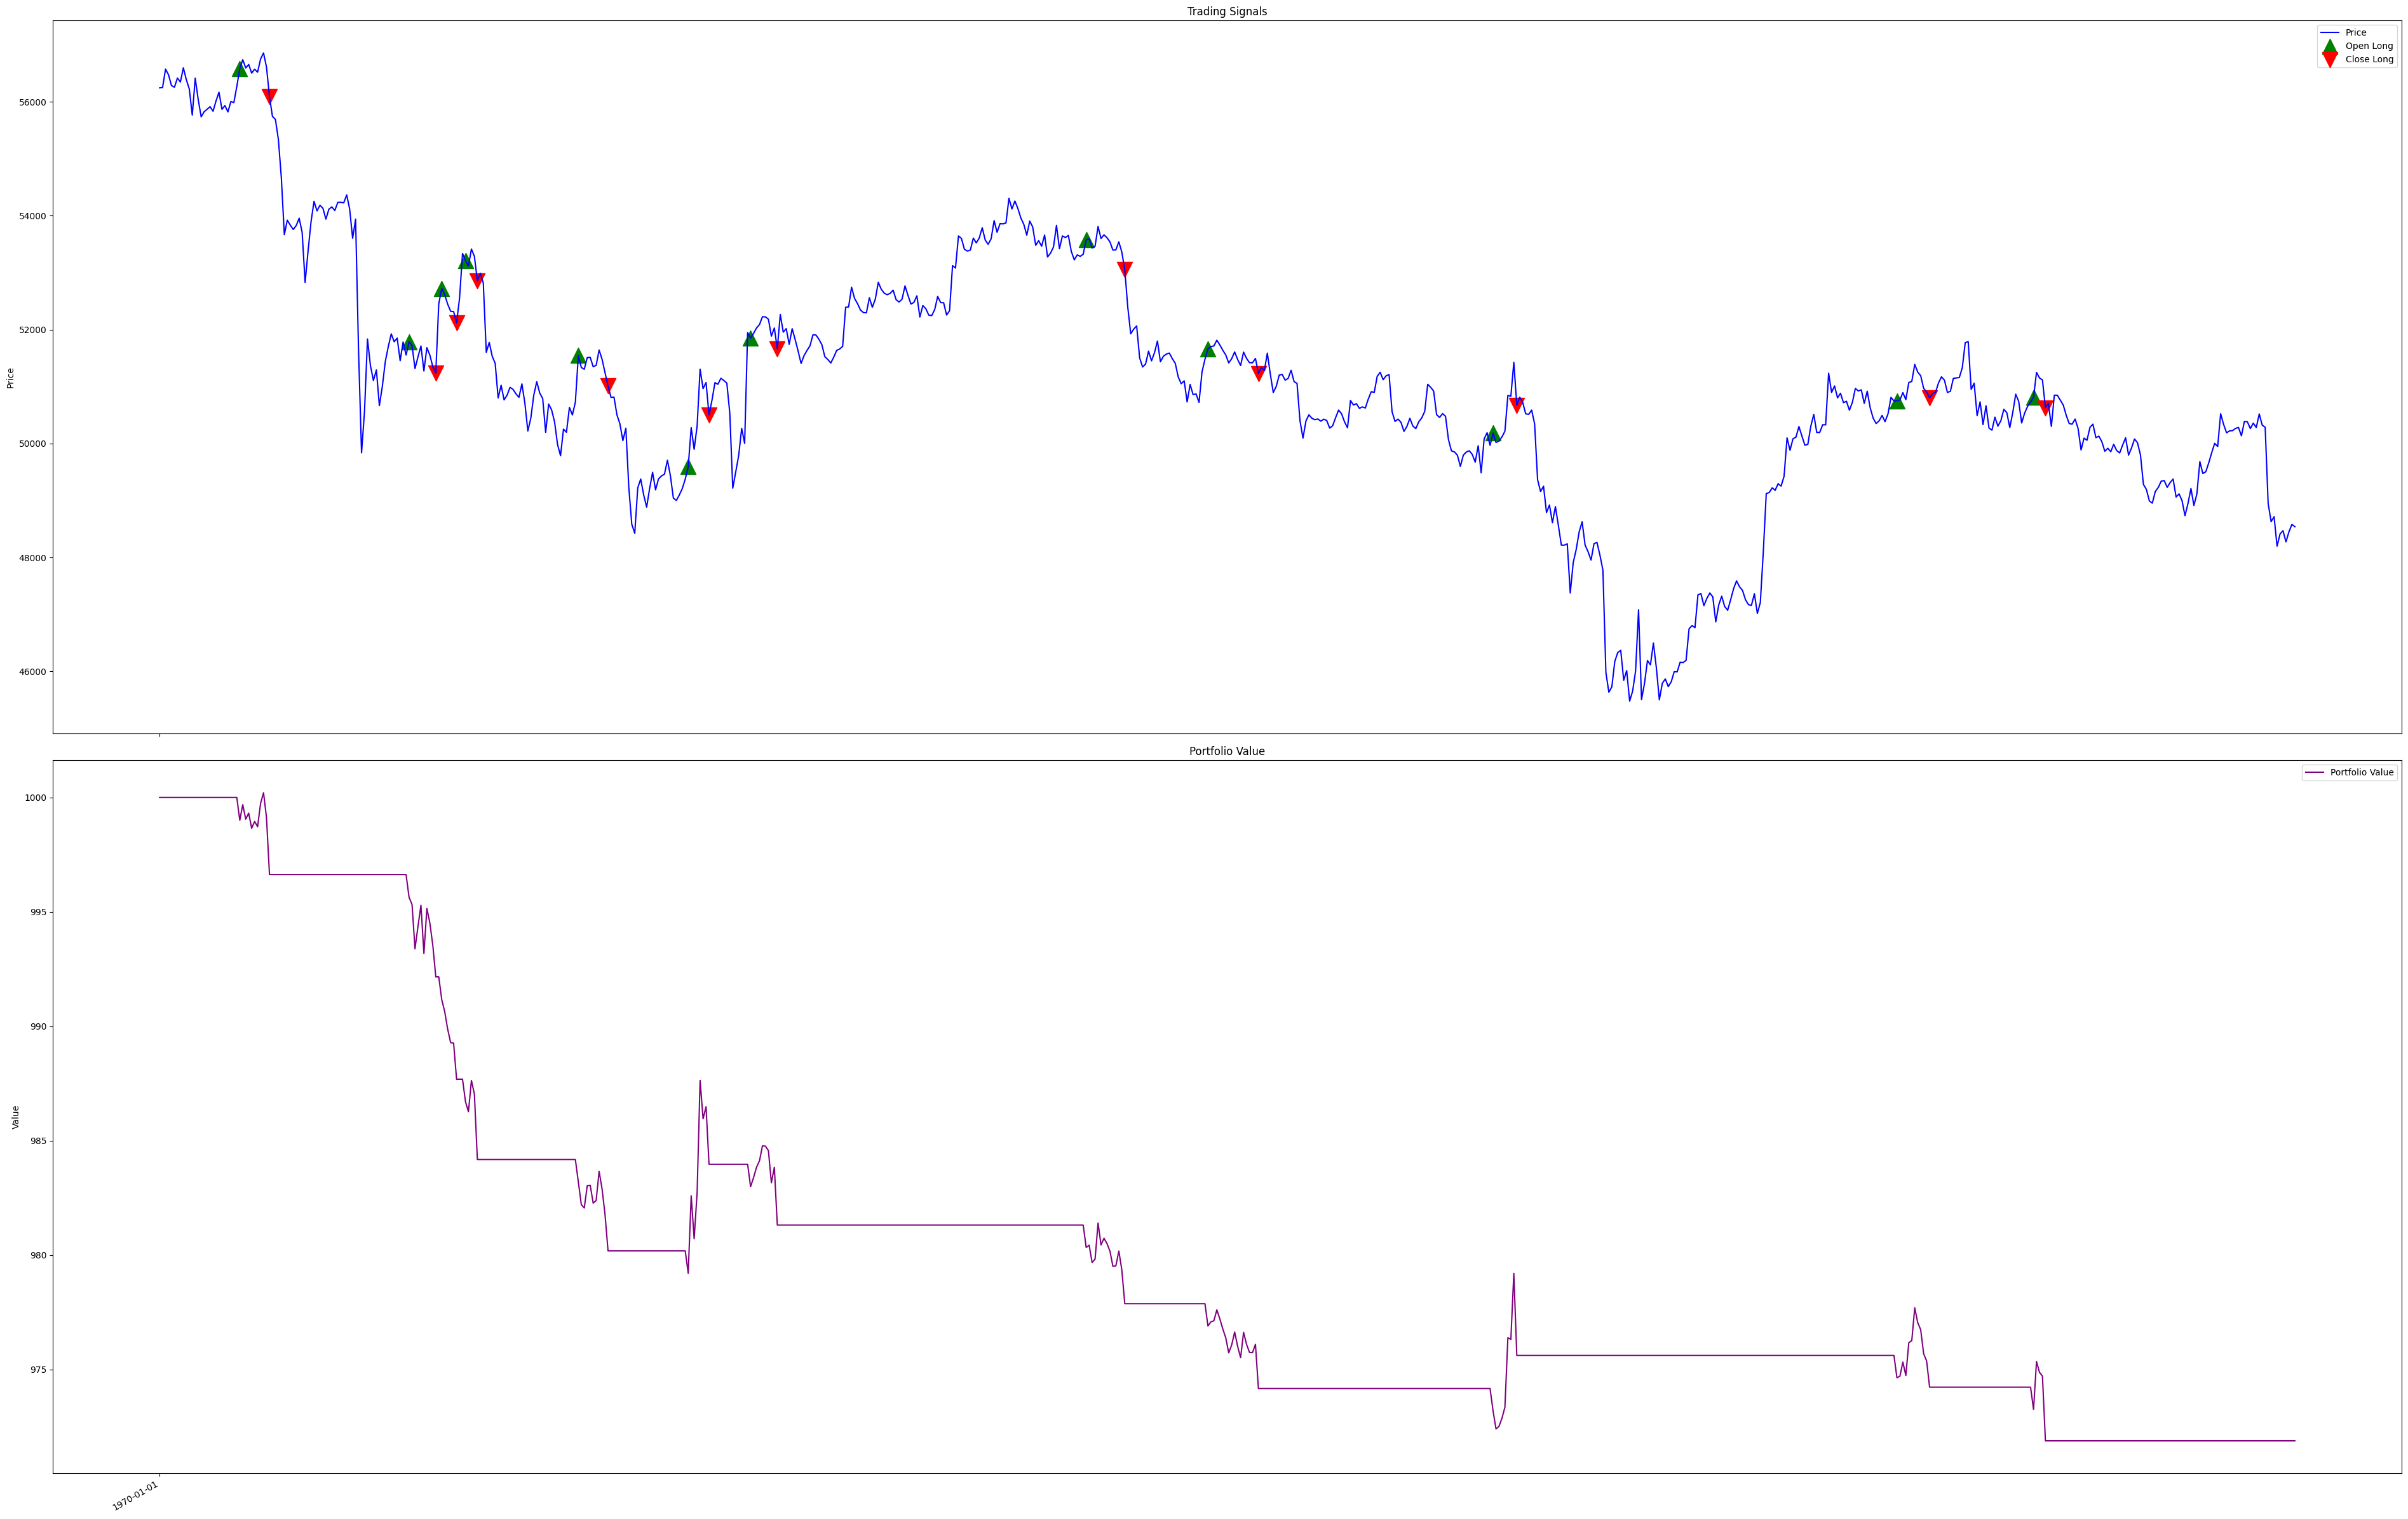

In [5]:
portfolio.plot_performance()